# Pretraining model
Our model right now generates random tokens. We need to pretrain it on a corpus of text. Lets's take the model we built:

In [2]:
import sys
sys.path.append('../')
from gpt_model.model import GPT
import torch
import numpy as np

GPT_CONFIG = {
    "vocab_size": 50257,
    "n_embd": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout": 0.1,
    "context_length": 256,
    "bias": False
}

torch.manual_seed(42)
model = GPT(GPT_CONFIG)
model.eval()


GPT(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768, bias=False)
        (key): Linear(in_features=768, out_features=768, bias=False)
        (value): Linear(in_features=768, out_features=768, bias=False)
        (output): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=76

In [3]:
def generate_text_simple(model, input_tensor, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    idx = input_tensor
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [4]:
import tiktoken

def text_to_tokens(text, tokenizer):
    encoding = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoding_tensor = torch.tensor(encoding).unsqueeze(0)
    return encoding_tensor

def tokens_to_text(tokens, tokenizer):
    text = tokenizer.decode(tokens.squeeze(0).tolist())
    return text

tokenizer = tiktoken.get_encoding("gpt2")

text = "Every efforte moves you"
token_ids = generate_text_simple(model, text_to_tokens(text, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG["context_length"])

print(tokens_to_text(token_ids, tokenizer))


Every efforte moves you batter inadequhelps likelihoodDespite parkedDriver prem Championshipsfill


Let's try to train the model on a corpus of text. We'll use the 1984 book.

In [5]:
with open("../data/1984.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:99])

It was a bright cold day in April, and the clocks were striking thirteen.
Winston Smith, his chin n


In [6]:
print("Total characters: ", len(text))
total_tokens = len(tokenizer.encode(text))
print("Total tokens: ", total_tokens)

Total characters:  273973
Total tokens:  66254


In [7]:
from dataloader import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text))
train_data = text[:split_idx]
val_data = text[split_idx:]


torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [8]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG['context_length']` or "
          "decrease the `training_ratio`")

We need a loss function to train the model. We'll use the cross-entropy loss. It calculates the loss between the predicted probabilities and the true probabilities of the next token. Let's implement it:

In [9]:
def compute_loss(input, target, model, device):
    input_tensor = input.to(device)
    target_tensor = target.to(device)
    logits = model(input_tensor)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_tensor.flatten())
    return loss

def compute_loader_loss(dataloader, model, device, num_batches=None):
    val_loss = 0.0
    if len(dataloader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input, target) in enumerate(dataloader):
        if i >= num_batches:
            break
        loss = compute_loss(input, target, model, device)
        val_loss += loss.item()
    return val_loss / num_batches

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

model.to(device)

with torch.no_grad():
    train_loss = compute_loader_loss(train_loader, model, device)
    val_loss = compute_loader_loss(val_loader, model, device)

print(f"Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Train loss: 11.0103, Validation loss: 11.0113


This allows us to compute the loss on the training and validation sets. We can use this to monitor the performance of the model during training.

We can now train the model.

Let's implement the training loop:

In [11]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = compute_loss(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = compute_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = compute_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, input_tensor=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = tokens_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [12]:
torch.manual_seed(42)
model = GPT(GPT_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.885, Val loss 9.859
Ep 1 (Step 000005): Train loss 8.397, Val loss 8.437
Ep 1 (Step 000010): Train loss 7.462, Val loss 7.665
Ep 1 (Step 000015): Train loss 7.233, Val loss 7.348
Ep 1 (Step 000020): Train loss 7.289, Val loss 7.304
Ep 1 (Step 000025): Train loss 7.178, Val loss 7.228
Ep 1 (Step 000030): Train loss 6.936, Val loss 7.122
Ep 1 (Step 000035): Train loss 6.947, Val loss 7.074
Ep 1 (Step 000040): Train loss 6.731, Val loss 7.014
Ep 1 (Step 000045): Train loss 6.670, Val loss 6.952
Ep 1 (Step 000050): Train loss 6.675, Val loss 6.892
Ep 1 (Step 000055): Train loss 6.663, Val loss 6.829
Ep 1 (Step 000060): Train loss 6.296, Val loss 6.761
Ep 1 (Step 000065): Train loss 6.390, Val loss 6.659
Ep 1 (Step 000070): Train loss 6.435, Val loss 6.647
Ep 1 (Step 000075): Train loss 6.442, Val loss 6.557
Ep 1 (Step 000080): Train loss 6.293, Val loss 6.493
Ep 1 (Step 000085): Train loss 6.210, Val loss 6.470
Ep 1 (Step 000090): Train loss 6.117, Val loss

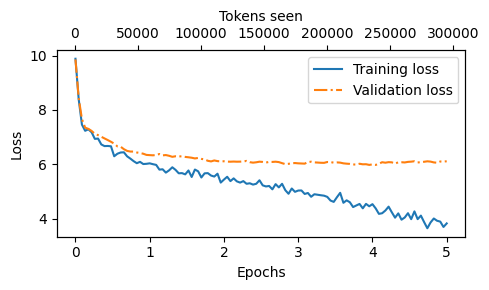

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Using temperature to control the randomness of the model. And top_k sampling to control the diversity of the model. We can now create a new generate function that uses temperature and top_k sampling.

In [14]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [15]:
torch.manual_seed(42)
model.to('cpu')
token_ids = generate(
    model=model,
    idx=text_to_tokens("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", tokens_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you turned out of gin. There was saying so the past the other, and


Lets save the weights of the model:

In [16]:
torch.save(model.state_dict(), "model.pth")

That way if we create another model with the same architecture, we can load the weights and continue training.

In [17]:
model = GPT(GPT_CONFIG)
model.load_state_dict(torch.load("model.pth"))
model.eval()

token_ids = generate(
    model=model,
    idx=text_to_tokens("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG["context_length"],
    top_k=25,
    temperature=1.4)

print("Output text:\n", tokens_to_text(token_ids, tokenizer))

/tmp/ipykernel_28613/562406528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Output text:
 Every effort moves you. Winston little seconds, she began
to possess, because you could feel


## Weights Load from OpenAI
Training on a small dataset is not enough to train a good model. And training on a large dataset requires a lot of computational resources. So we can use the weights that OpenAI trained and released.

In [18]:
# I use the script create by Sebastian Raschka to download the weights.
from gpt_weights_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")



2024-10-02 00:50:25.757197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 00:50:25.835860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 00:50:25.865755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 00:50:26.022109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 00:50:27.135893: W tensorflow/compiler/tf2

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2024-10-02 00:50:31.661031: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


In [19]:
print(settings)
print(params.keys())



{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


now we can assign the weights to our model:

In [22]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt: GPT, params: dict):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].att.query.weight = assign(
            gpt.transformer_blocks[b].att.query.weight, q_w.T)
        gpt.transformer_blocks[b].att.key.weight = assign(
            gpt.transformer_blocks[b].att.key.weight, k_w.T)
        gpt.transformer_blocks[b].att.value.weight = assign(
            gpt.transformer_blocks[b].att.value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].att.query.bias = assign(
            gpt.transformer_blocks[b].att.query.bias, q_b)
        gpt.transformer_blocks[b].att.key.bias = assign(
            gpt.transformer_blocks[b].att.key.bias, k_b)
        gpt.transformer_blocks[b].att.value.bias = assign(
            gpt.transformer_blocks[b].att.value.bias, v_b)

        gpt.transformer_blocks[b].att.output.weight = assign(
            gpt.transformer_blocks[b].att.output.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].att.output.bias = assign(
            gpt.transformer_blocks[b].att.output.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].ff.net[0].weight = assign(
            gpt.transformer_blocks[b].ff.net[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].ff.net[0].bias = assign(
            gpt.transformer_blocks[b].ff.net[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].ff.net[2].weight = assign(
            gpt.transformer_blocks[b].ff.net[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].ff.net[2].bias = assign(
            gpt.transformer_blocks[b].ff.net[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].ln1.scale = assign(
            gpt.transformer_blocks[b].ln1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].ln1.shift = assign(
            gpt.transformer_blocks[b].ln1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].ln2.scale = assign(
            gpt.transformer_blocks[b].ln2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].ln2.shift = assign(
            gpt.transformer_blocks[b].ln2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.ln_f.scale = assign(gpt.ln_f.scale, params["g"])
    gpt.ln_f.shift = assign(gpt.ln_f.shift, params["b"])
    gpt.head.weight = assign(gpt.head.weight, params["wte"])
    
GPT_CONFIG.update({"context_length": 1024, "bias": True})
gpt = GPT(GPT_CONFIG)
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPT(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (output): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768,

In [24]:
token_ids = generate(
    model=gpt,
    idx=text_to_tokens("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG["context_length"],
    top_k=25,
    temperature=1.4)

print("Output text:\n", tokens_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you around the world, and sometimes, I'm pretty much always getting out of
